In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
dataframe = pd.read_csv('../../Data/data_fix_temp.txt')
columns_to_drop=[
    't_obs', 
    'lokasi',
    'Date', 
    'con_prec.mm.', 
    'mic_prec.mm.', 
    'sha_prec.mm.',
    'lcloud...',	
    'mcloud...', 
    'hcloud...', 
    'clmix.kg.kg.', 
    'wamix.kg.kg.', 
    'hari', 
    'UTC', 
    'LAT', 
    'LON',
    ]

features =  dataframe.drop(columns=columns_to_drop) 
target = dataframe['t_obs']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
X_train.columns

Index(['suhu2m.degC.', 'dew2m.degC.', 'rh2m...', 'wspeed.m.s.', 'wdir.deg.',
       'surpre.Pa.', 'outlr.W.m2.', 'pblh.m.', 'lifcl.m.', 'cape.j.kg.',
       'mdbz', 't950.degC.', 'rh950...', 'ws950.m.s.', 'wd950.deg.',
       't800.degC.', 'rh800...', 'ws800.m.s.', 'wd800.deg.', 't500.degC.',
       'rh500...', 'ws500.m.s.', 'wd500.deg.', 'ELEV'],
      dtype='object')

In [8]:
X_train.shape[1]

24

In [23]:
# Build the LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(len(X_train.columns), )))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Dense(1, activation='linear'))

In [24]:
model.compile(loss = tf.keras.losses.MeanAbsoluteError(), #mae stands for mean absolute error
              optimizer = tf.keras.optimizers.Adam(), # Adam
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.fit( X_train_scaled, y_train, epochs = 50)

Epoch 1/50
13607/13607 [==============================] - 45s 3ms/step - loss: 1.9835 - mean_absolute_error: 1.9835
Epoch 2/50
13607/13607 [==============================] - 45s 3ms/step - loss: 1.2509 - mean_absolute_error: 1.2509
Epoch 3/50
13607/13607 [==============================] - 45s 3ms/step - loss: 1.2293 - mean_absolute_error: 1.2293
Epoch 4/50
13607/13607 [==============================] - 45s 3ms/step - loss: 1.2159 - mean_absolute_error: 1.2159
Epoch 5/50
13607/13607 [==============================] - 44s 3ms/step - loss: 1.2047 - mean_absolute_error: 1.2047
Epoch 6/50
13607/13607 [==============================] - 44s 3ms/step - loss: 1.1982 - mean_absolute_error: 1.1982
Epoch 7/50
13607/13607 [==============================] - 44s 3ms/step - loss: 1.1916 - mean_absolute_error: 1.1916
Epoch 8/50
13607/13607 [==============================] - 44s 3ms/step - loss: 1.1881 - mean_absolute_error: 1.1881
Epoch 9/50
13607/13607 [==============================] - 45s 3ms/step -

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

test_predictions = model.predict(X_test_scaled)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, test_predictions)
rmse = mean_squared_error(y_test, test_predictions, squared=False)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}\n')

3402/3402 [==============================] - 3s 964us/step
Mean Squared Error: 3.12094880218144
Root Mean Squared Error: 1.7666207295799063
Mean Absolute Error: 1.3760889828251655
R2 Score: 0.6941290132761508



In [26]:
test_predictions

array([[30.79541 ],
       [28.096952],
       [25.637838],
       ...,
       [30.265974],
       [27.16228 ],
       [25.298769]], dtype=float32)

In [27]:
#OUTPUT

combined = pd.concat([dataframe[['Date', 'lokasi', 'suhu2m.degC.', 'LON','LAT','ELEV']],y_test, pd.Series(test_predictions[:, 0], index = X_test.index)], axis=1)
combined.columns = ['Date', 'lokasi', 'suhu2m.degC.', 'LON','LAT','ELEV', 't_obs', 'prediction']
combined = combined.dropna()
combined.tail(15)

,Date,lokasi,suhu2m.degC.,LON,LAT,ELEV,t_obs,prediction
544260,2023-04-05 09:00:00,99992,29.1739,106.7564,-6.30253,41,35.4,30.818100
544261,2023-04-10 00:00:00,99992,24.9934,106.7564,-6.30253,41,25.6,25.465549
544262,2023-04-10 03:00:00,99992,30.2816,106.7564,-6.30253,41,26.4,30.726896
544263,2023-04-10 06:00:00,99992,31.1585,106.7564,-6.30253,41,30.6,31.789478
544264,2023-04-10 09:00:00,99992,30.3046,106.7564,-6.30253,41,31.4,31.369902
544265,2023-04-11 00:00:00,99992,24.3057,106.7564,-6.30253,41,26.5,25.079844
544266,2023-04-11 03:00:00,99992,30.3986,106.7564,-6.30253,41,32.0,31.099171
544267,2023-04-11 06:00:00,99992,31.1714,106.7564,-6.30253,41,33.2,31.966671
544268,2023-04-11 09:00:00,99992,30.2010,106.7564,-6.30253,41,29.8,31.470987
544269,2023-04-12 00:00:00,99992,25.1158,106.7564,-6.30253,41,25.8,25.391277


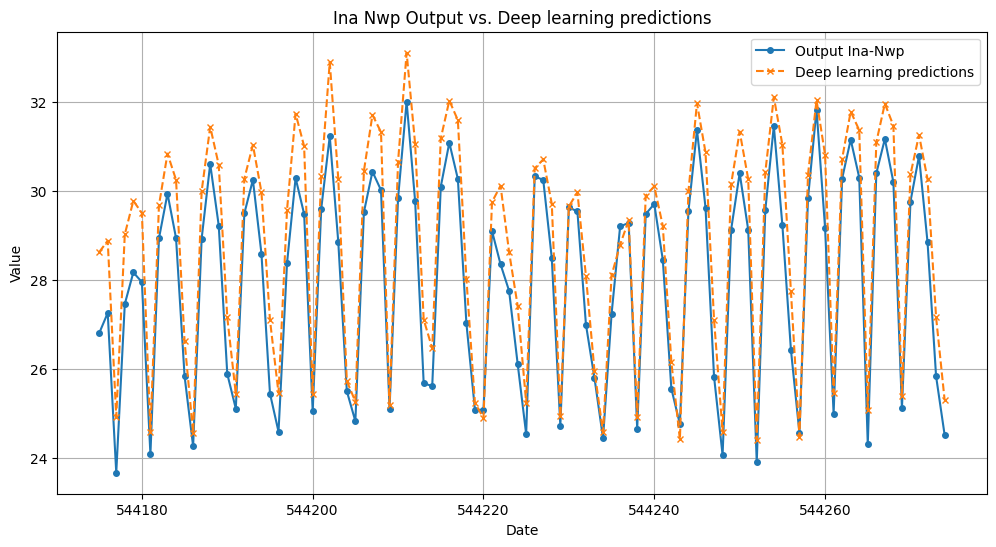

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(combined.iloc[-75:].index, combined.iloc[-75:]['suhu2m.degC.'], label='Output Ina-Nwp', marker='o', markersize=4)
plt.plot(combined.iloc[-75:].index, combined.iloc[-75:]['prediction'], label='Deep learning predictions', linestyle='--', marker='x', markersize=4)

plt.title('Ina Nwp Output vs. Deep learning predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()

plt.show()

In [22]:
del model

In [29]:
inp_nwp = pd.read_csv('../../Data/MONAS-input_nwp_compile.csv')


test = inp_nwp.drop(columns=['Date', 'LAT', 'LON', 'prec_nwp'])
test = test.rename(
    columns={
        'suhu2m(degC)' : 'suhu2m.degC.',
        'dew2m(degC)' : 'dew2m.degC.',
        'rh2m(%)' : 'rh2m...',
        'wspeed(m/s)' : 'wspeed.m.s.',
        'wdir(deg)' : 'wdir.deg.',
        'lcloud(%)' : 'lcloud...',
        'mcloud(%)' : 'mcloud...' ,
        'hcloud(%)' : 'hcloud...',
        'surpre(Pa)' : 'surpre.Pa.' ,
        'clmix(kg/kg)' : 'clmix.kg.kg.' ,
        'wamix(kg/kg)' : 'wamix.kg.kg.' ,
        'outlr(W/m2)' : 'outlr.W.m2.' ,
        'pblh(m)' : 'pblh.m.',
        'lifcl(m)' : 'lifcl.m.' ,
        'cape(j/kg)' : 'cape.j.kg.' ,
        'mdbz' : 'mdbz' ,
        't950(degC)' : 't950.degC.' ,
        'rh950(%)' : 'rh950...',
        'ws950(m/s)' : 'ws950.m.s.' ,
        'wd950(deg)' : 'wd950.deg.' ,
        't800(degC)' : 't800.degC.' ,
        'rh800(%)' : 'rh800...' ,
        'ws800(m/s)' : 'ws800.m.s.',
        'wd800(deg)' : 'wd800.deg.' ,
        't500(degC)' : 't500.degC.' ,
        'rh500(%)' : 'rh500...' ,
        'ws500(m/s)' : 'ws500.m.s.' ,
        'wd500(deg)' : 'wd500.deg.',
})
#hcloud..., wamix.kg.kg., lcloud..., lokasi, clmix.kg.kg., mcloud...
# test = test.drop(columns=['lcloud...','mcloud...', 'hcloud...', 'clmix.kg.kg.', 'wamix.kg.kg.',])

# y_val_pred = model.predict(X_test)

# mse_val = mean_squared_error(y_test, y_val_pred)
# rmse_val = mean_squared_error(y_test, y_val_pred, squared=False)
# mae_val = mean_absolute_error(y_test, y_val_pred)
# r2_val = r2_score(y_test, y_val_pred)

# print('Tanpa Scaling')
# print(f'Mean Squared Error: {mse_val}')
# print(f'Root Mean Squared Error: {rmse_val}')
# print(f'Mean Absolute Error: {mae_val}')
# print(f'R2 Score: {r2_val}\n')